In [54]:
from nptdms import TdmsFile
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.cluster.hierarchy as hac
import math
import numpy as np
from random import sample



In [2]:
class SegHub(object):

    def segment_and_plot(self, df, model='l1', count=0, n_bkps=5):
        '''
        recieves a segment as input and runs ruptures changeppoint detection algorithm to segment a
        punch into subsequences. Eventually, it plots the segments,
        saves the plot and returns a dataframe containing all segments numbered begining with 1
        '''
        dfs = pd.DataFrame()
        lower_bound = 0
        upper_bound = len(df)

        # change point detection
        #model = "l1"  # "l2", "rbf"

        data = df[lower_bound:upper_bound].values
        algo = rpt.Dynp(model=model, min_size=15, jump=15).fit(data)
        my_bkps_t = algo.predict(n_bkps)

        j = 0
        lower_bound_temp = lower_bound
     
        while j < n_bkps :
            df_temp = pd.DataFrame({j: df[my_bkps_t[j]:my_bkps_t[j+1]]})
            df_temp = df_temp.reset_index(drop=True)
            dfs = pd.concat([dfs, df_temp], axis=1)
            #df[lower_bound_temp:my_bkps_t[j]+lower_bound].plot()
            #lower_bound_temp = my_bkps_t[j]+lower_bound
            j = j + 1
        #plt.savefig('plot_' + model + '_' + str(count) + '.png')
        #plt.clf()
        #print(dfs)
        return dfs

    def extract_hub(self, df_force, df_stroke, start=5000, threshold=0.5):
        '''
        returns data frame containing each punch segment derived by the df_stroke timeseries data
        '''

        segments = []
        dfs = pd.DataFrame()
        flag = False
        begin_temp = 0
        count = 0
        end = len(df_stroke)
        for i in range(start, end):
            if not(flag) and df_stroke[i] > threshold:
                flag = True
                begin_temp = i
            elif flag and df_stroke[i] > threshold:
                continue
            elif flag and df_stroke[i] < threshold:
                seg_temp = (begin_temp, i)
                segments.append(seg_temp)
                df_temp = pd.DataFrame({count: df_force[begin_temp:i]})
                df_temp = df_temp.reset_index(drop=True)
                dfs = pd.concat([dfs, df_temp], axis=1)

                flag = False
                count = count + 1
            else:
                continue
        return dfs

    def plot_all(df_to_plot):
        '''
        plots all columns in the dataframe
        '''
        ax = None
        for index in df_to_plot:
            ax = sns.tsplot(ax=ax, data=df_to_plot[index].values, err_style="unit_traces")
        plt.savefig('test.png')

    def separate_subsequence(df_segments, target_segment):
        dfs = pd.DataFrame()

        for j in range(0, len(df_segments)):
            df_temp = pd.DataFrame({j: df_segments[j]})
            df_temp = df_temp.reset_index(drop=True)   
            dfs = pd.concat([dfs, df_temp], axis=1)

    def DTWDistance(self, s1, s2):
        '''
        plots all columns in the dataframe
        '''
        DTW = {}

        for i in range(len(s1)):
            DTW[(i, -1)] = float('inf')
        for i in range(len(s2)):
            DTW[(-1, i)] = float('inf')
        DTW[(-1, -1)] = 0

        for i in range(len(s1)):
            for j in range(len(s2)):
                dist = (s1[i]-s2[j])**2
                DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

        return math.sqrt(DTW[len(s1)-1, len(s2)-1])





In [3]:
 # load in data, take the TDMS data type as example
tdms_file = TdmsFile(".\\AKF_SS-FW2-H04521-H05000.tdms")
# preprocessing the data type 'DINT'
df_all = tdms_file.object('Untitled').as_dataframe()


In [4]:
df_force = df_all['Stempel_1 (Formula Result)']
df_stroke = df_all['Position_Ma']



In [6]:
 SEH = SegHub()
# Init lists and dfs
segmentation_1 = []
segmentation_2 = []
segmentation_3 = []
segmentation_4 = []
segmentation_5 = []
sub_segmentation = []
df_seg = pd.DataFrame()
# Extract all punches of the dataset
df_punches = SEH.extract_hub(df_force, df_stroke)
#print(df_punches.describe())


In [6]:
x=0
for i in df_punches:

        # first changepoint detection on whole punch
        # second changepoint detection on 
        punch_seg = SEH.segment_and_plot(df_punches[i].dropna(), 'l1', i)
        #sub_punch_seg = SEH.segment_and_plot(punch_seg[6].dropna(), 'rbf', 7 + i, 4)

        # append to corresponding list
        segmentation_1.append(np.asarray(punch_seg[0]))
        segmentation_2.append(np.asarray(punch_seg[1]))
        segmentation_3.append(np.asarray(punch_seg[2]))
        segmentation_4.append(np.asarray(punch_seg[3]))
        segmentation_5.append(np.asarray(punch_seg[4]))
        #sub_segmentation.append(sub_punch_seg)
        print(x)
        x = 1+x
        #create dataframe
        #df_temp = pd.DataFrame({i: sub_segmentation[i][2].dropna()})
        #df_temp = df_temp.reset_index(drop=True)
        # df_temp = pd.DataFrame(sub_segmentation[i][2])
        # df_seg = df_seg.append(df_temp)
        #df_seg = pd.concat([df_seg, df_temp], axis=1)

#print(df_seg.describe())



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
segmentation_1 = pd.read_csv("segmentation_1.csv")
segmentation_2 = pd.read_csv("segmentation_2.csv")
segmentation_3 = pd.read_csv("segmentation_3.csv")
segmentation_4 = pd.read_csv("segmentation_4.csv")
segmentation_5 = pd.read_csv("segmentation_5.csv")

In [30]:
minlen = 6348
lens = []
for i in range(0,478):
    lx = len(segmentation_1.iloc[i,:].dropna())
    lens.append(lx)
    if lx < minlen:
       minlen = lx

In [37]:
segmentation_1 = segmentation_1.iloc[:,0:150]

In [67]:
# Randomly sample 80% of your dataframe
df_percent = segmentation_1.sample(frac=0.8)

df_rest = segmentation_1.iloc[~segmentation_1.index.isin(df_percent.index)]


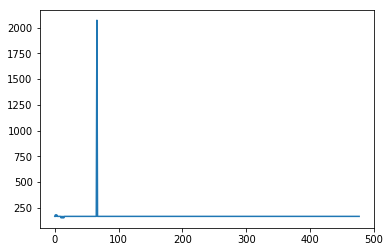

In [50]:
plt.plot(lens)

In [69]:
z = hac.linkage(df_percent, 'ward')

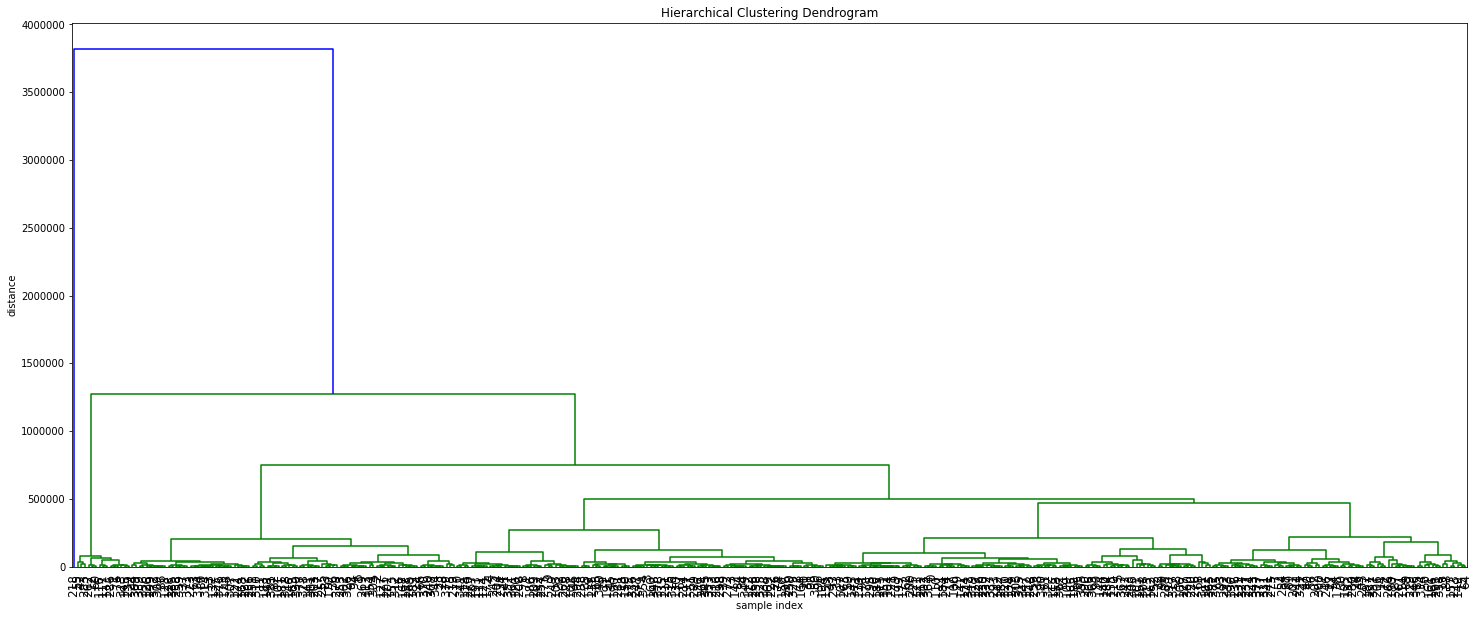

In [70]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
)
plt.show()

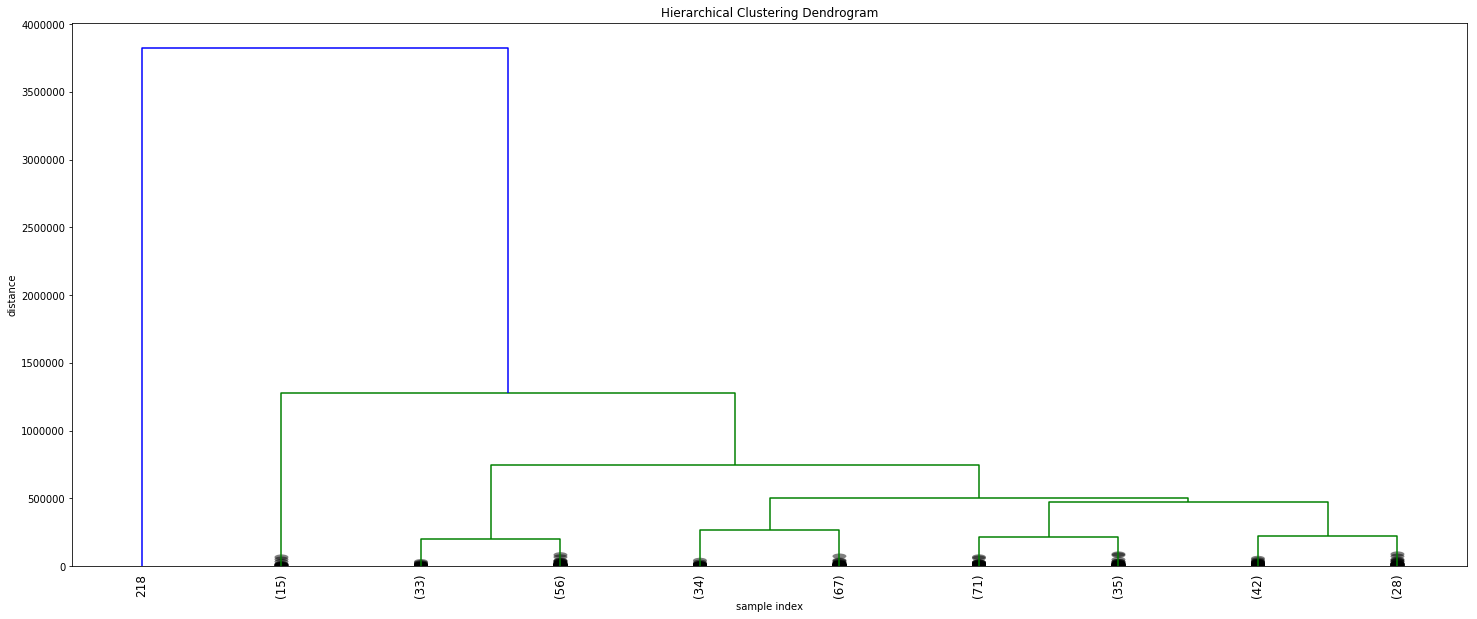

In [72]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    z,
    truncate_mode = 'lastp',
    p = 10,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()

Cluster 2 number of entries 366


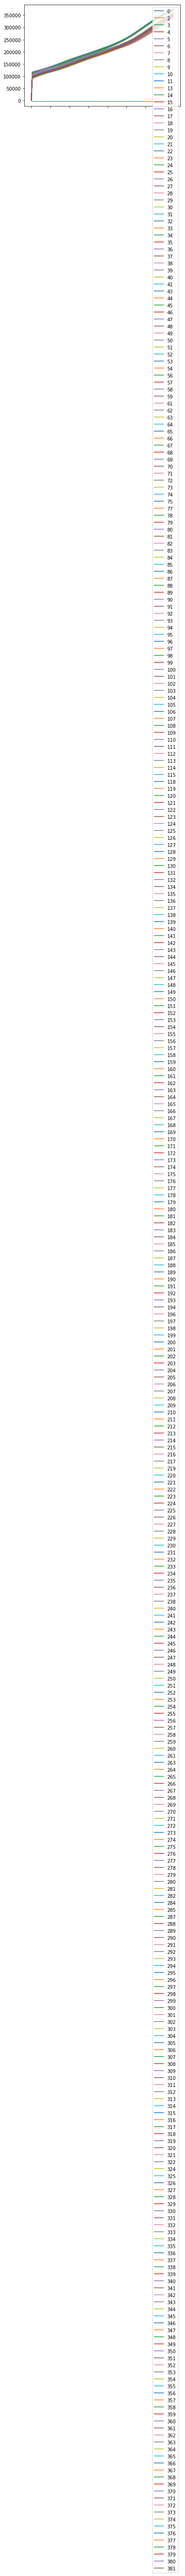

Cluster 1 number of entries 15


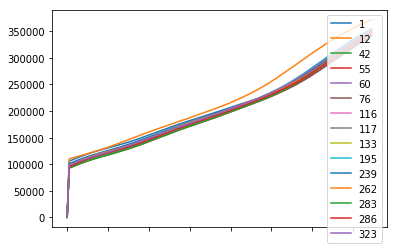

Cluster 3 number of entries 1


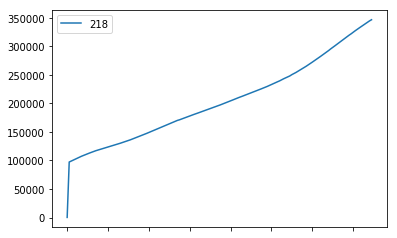

In [76]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(timeSeries, z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot()
            plt.show()
    return results
clusters = print_clusters(segmentation_1, z, 3, plot=True)